In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import librosa
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind, mannwhitneyu, skew, kurtosis, f_oneway

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from joblib import Parallel, delayed

In [3]:
from utils import load_config, perform_statistical_tests
from data.load.data_loader import get_codecfake_audio_id_list, load_audio_data
from features import (
    LowLevelFeatureExtractor, 
    HighLevelFeatureExtractor, 
    plot_low_level_feature_dist, 
    plot_high_level_feature_dist, 
    perform_pca_and_plot
)

In [4]:
config    = load_config()
cache_dir = config['data_paths']['codecfake']['cache_files']
audio_ids = get_codecfake_audio_id_list()

In [5]:
iterable_ds = load_audio_data(
    audio_ids=audio_ids[:500],
    dataset='codecfake',
    cache_dir=cache_dir
)

In [6]:
rows = []
for audio in iterable_ds:
    audio_id  = audio['audio_id']
    audio_arr = audio['audio']['array']
    srate     = audio['audio']['sampling_rate']
    real_fake = audio['real_or_fake']

    rows.append({
        'audio_id': audio_id,
        'audio_arr': audio_arr,
        'srate': srate,
        'real_or_fake': real_fake
    })

In [7]:
df = pd.DataFrame(rows)
df.head()

audio_id                                          audio_arr  srate  \
0  p225_002  [-0.0045166015625, -0.00665283203125, -0.00607...  48000   
1  p225_002  [0.001953125, 0.001556396484375, 0.00164794921...  16000   
2  p225_002  [-0.001220703125, -0.001129150390625, -0.00103...  24000   
3  p225_002  [0.001861572265625, 0.001922607421875, 0.00195...  16000   
4  p225_002  [-0.00335693359375, -0.0032958984375, -0.00320...  48000   

  real_or_fake  
0            R  
1          F03  
2          F04  
3          F01  
4          F05

### Detailed Low Level Features

In [8]:
audio_processor = LowLevelFeatureExtractor(target_sr=16000, include_only=['spectral', 'prosodic', 'voice_quality'])

In [9]:
low_level_features   = pd.DataFrame(list(audio_processor.low_level_feature_generator(df.iloc[:20])))
low_level_feature_df = pd.DataFrame(low_level_features)
low_level_feature_df.head()

Processing Audios: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


audio_id real_or_fake                                  spectral_centroid  \
0  p225_002            R  [829.4145187838415, 661.496958455381, 442.6783...   
1  p225_002          F03  [1069.4187478998572, 637.0547651030942, 370.36...   
2  p225_002          F04  [729.9637507875887, 522.6023419619487, 421.068...   
3  p225_002          F01  [521.3902225491731, 438.1140428433425, 351.525...   
4  p225_002          F05  [720.8583200851683, 664.5686611174235, 583.125...   

                                  spectral_bandwidth  \
0  [1510.326546535265, 1383.9102101047506, 1174.7...   
1  [1940.535132849958, 1529.5960988060424, 1148.6...   
2  [1562.8883935041792, 1316.9819802115717, 1250....   
3  [1368.733604690056, 1253.619013189369, 1133.14...   
4  [1426.667105670598, 1362.2742731282342, 1324.2...   

                                   spectral_contrast  \
0  [11.291859341535664, 16.916747499376296, 22.22...   
1  [18.39940091484689, 21.239724615563638, 20.840...   
2  [12.776180144990716, 16.68635227210276, 27.924...   
3  [19.988859797431736, 24.837846454345446, 21.83...   
4  [18.752303484237306, 19.081640178500304, 23.58...   

                                   spectral_flatness  \
0  [0.002798787648578932, 0.0008228998272063862, ...   
1  [0.0026924060781607037, 0.0005084176100987905,...   
2  [0.0011371893766648053, 0.00035142732287487204...   
3  [0.00038271294858709814, 0.0001961472135381932...   
4  [0.0014925099428683398, 0.0009488775957742423,...   

                                    spectral_rolloff  \
0  [1867.1875, 1226.5625, 687.5, 687.5, 898.4375,...   
1  [2835.9375, 968.75, 250.0, 414.0625, 734.375, ...   
2  [1429.6875, 617.1875, 273.4375, 195.3125, 218....   
3  [679.6875, 335.9375, 132.8125, 4218.75, 4500.0...   
4  [1554.6875, 1257.8125, 1023.4375, 914.0625, 96...   

                                  zero_crossing_rate  \
0  [0.00537109375, 0.005859375, 0.00634765625, 0....   
1  [0.00146484375, 0.001953125, 0.001953125, 0.00...   
2  [0.00634765625, 0.00732421875, 0.00732421875, ...   
3  [0.001953125, 0.00244140625, 0.02783203125, 0....   
4  [0.00537109375, 0.005859375, 0.0078125, 0.0073...   

                                               mfccs  \
0  [-493.46367947184245, -505.3487799052732, -515...   
1  [-540.5051397245809, -538.5494203495595, -536....   
2  [-518.7511977161419, -519.60214768256, -525.26...   
3  [-527.5679663278828, -527.3073295996451, -526....   
4  [-527.3005230751635, -526.1854591447704, -534....   

                                         chroma_stft  ...  \
0  [0.9684745830596301, 0.913118083385125, 0.9379...  ...   
1  [0.9677985648656308, 0.787370244795954, 0.9266...  ...   
2  [0.886233560485923, 0.965461538250158, 0.90895...  ...   
3  [0.7183639023327838, 0.5640943858745837, 0.800...  ...   
4  [0.6626814448860227, 0.737018679479439, 0.9999...  ...   

                                              pauses  \
0  [(0.0, 1.0973333333333333), (1.625333333333333...   
1  [(0.0, 1.088), (2.3200000000000003, 2.552), (3...   
2  [(0.0, 1.0893333333333333), (1.625333333333333...   
3  [(0.0, 0.7770625000000002), (1.289062500000000...   
4  [(0.0, 1.09125), (1.62725, 1.77925), (2.331250...   

                                            formants jitter_local  jitter_rap  \
0  {'F1_mean': 879.0069982463549, 'F1_stdev': 417...     0.019678    0.008011   
1  {'F1_mean': 893.3805848953405, 'F1_stdev': 412...     0.023747    0.009809   
2  {'F1_mean': 872.0603492791237, 'F1_stdev': 420...     0.021938    0.009088   
3  {'F1_mean': 863.8373523983494, 'F1_stdev': 456...     0.023562    0.010110   
4  {'F1_mean': 900.8769212847095, 'F1_stdev': 429...     0.025659    0.010528   

  jitter_ppq5 shimmer_local  shimmer_apq3  shimmer_apq5  shimmer_dda  \
0    0.009951      0.071643      0.020144      0.026690     0.060432   
1    0.010080      0.069989      0.020712      0.031683     0.062136   
2    0.011882      0.101849      0.041155      0.055187     0.123465   
3    0.010417      0.068337

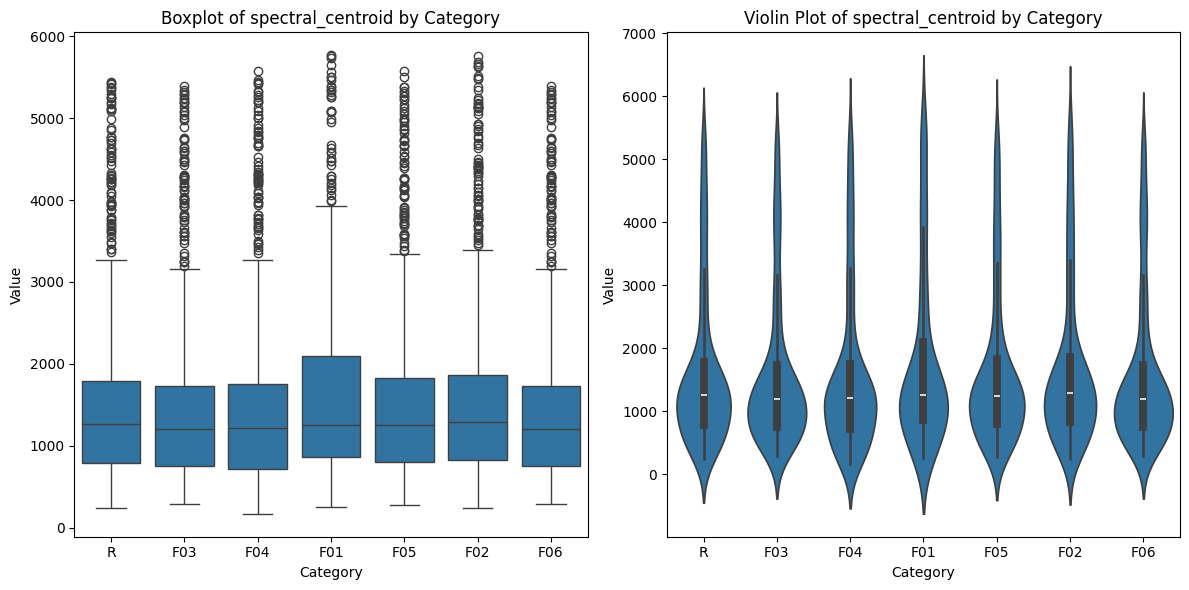

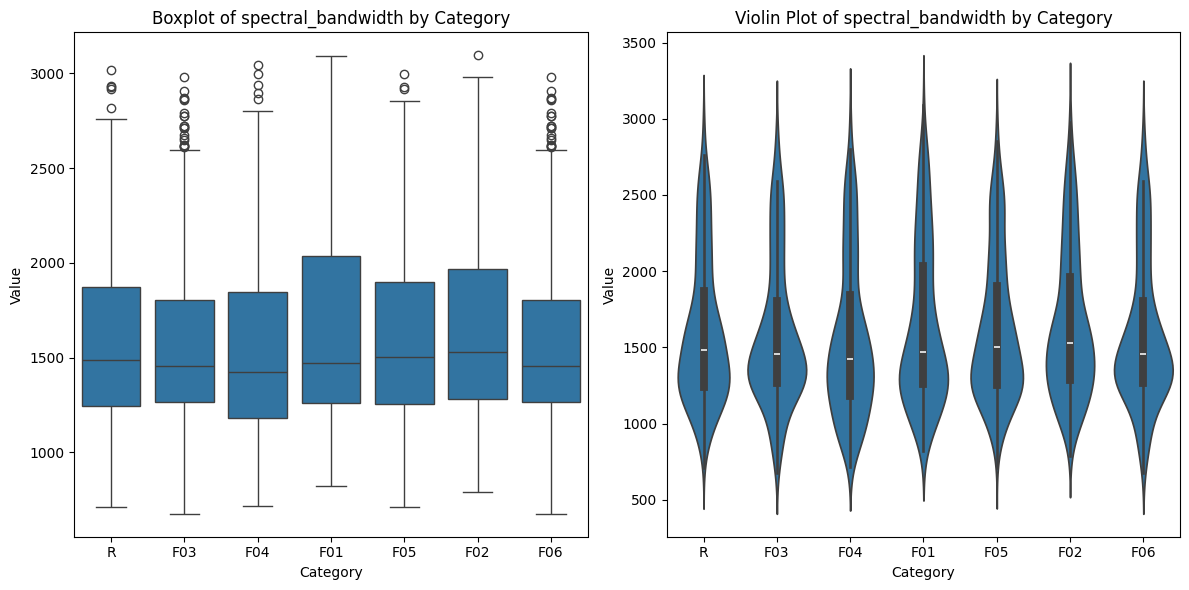

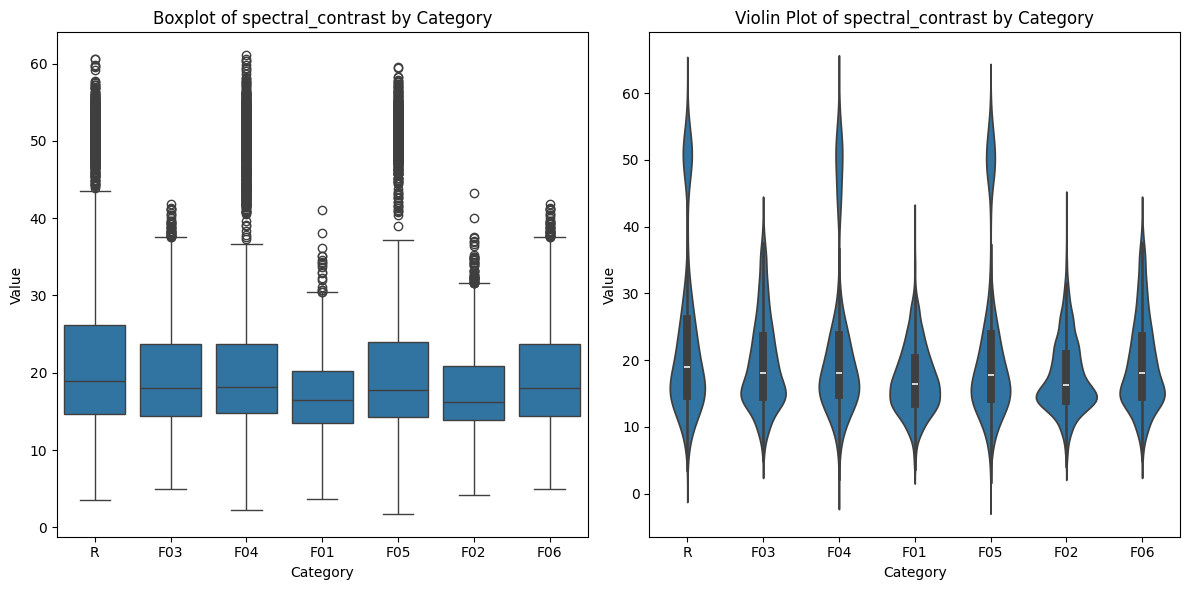

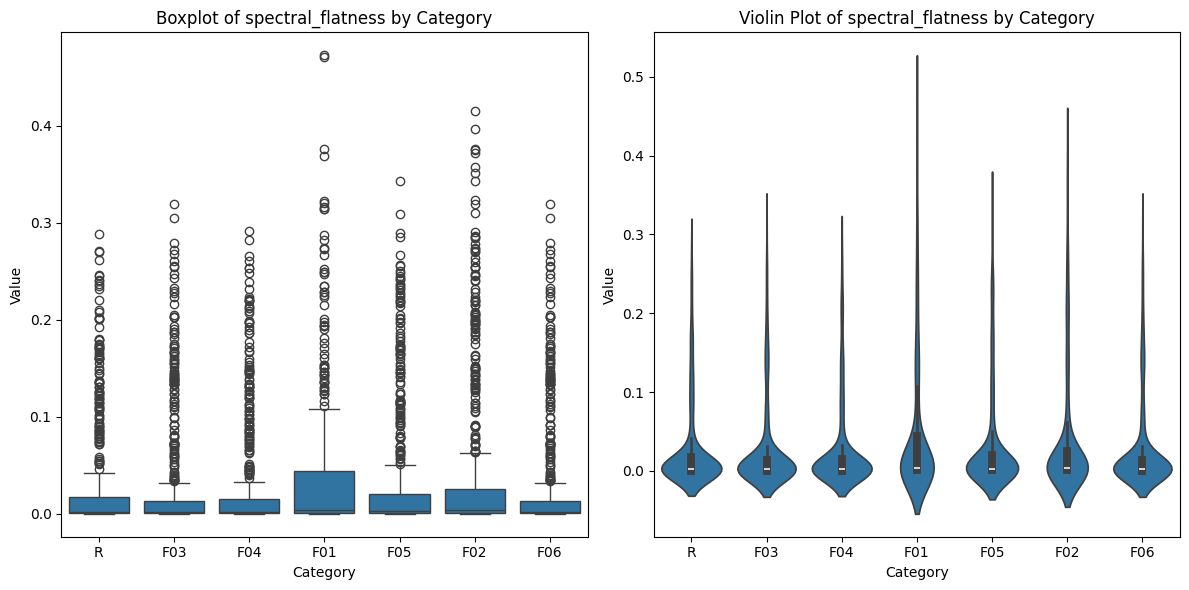

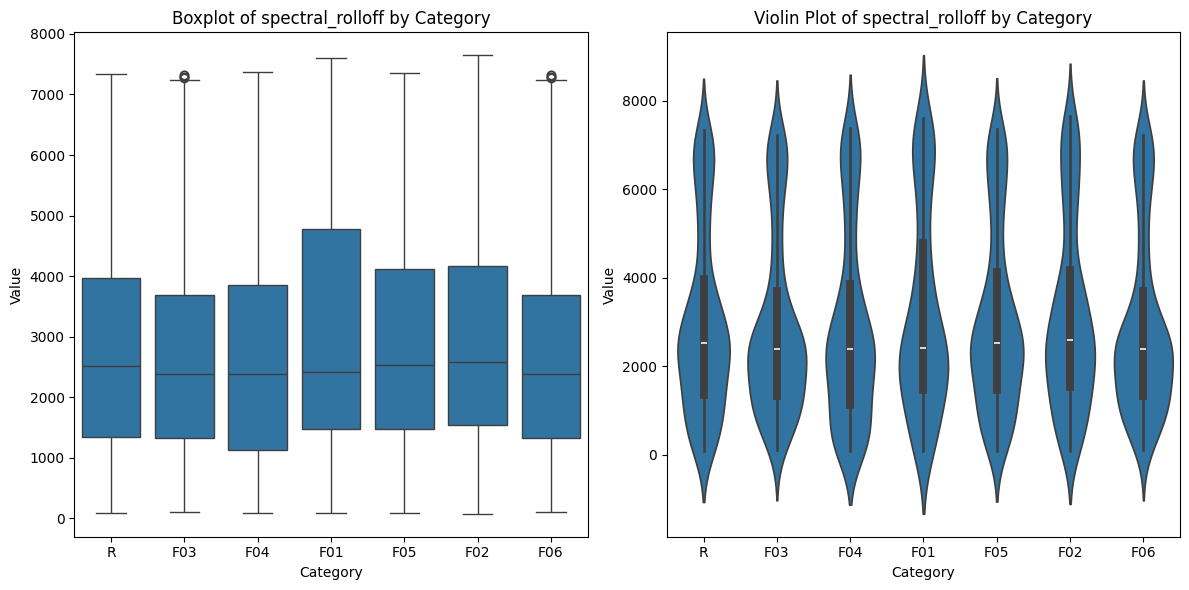

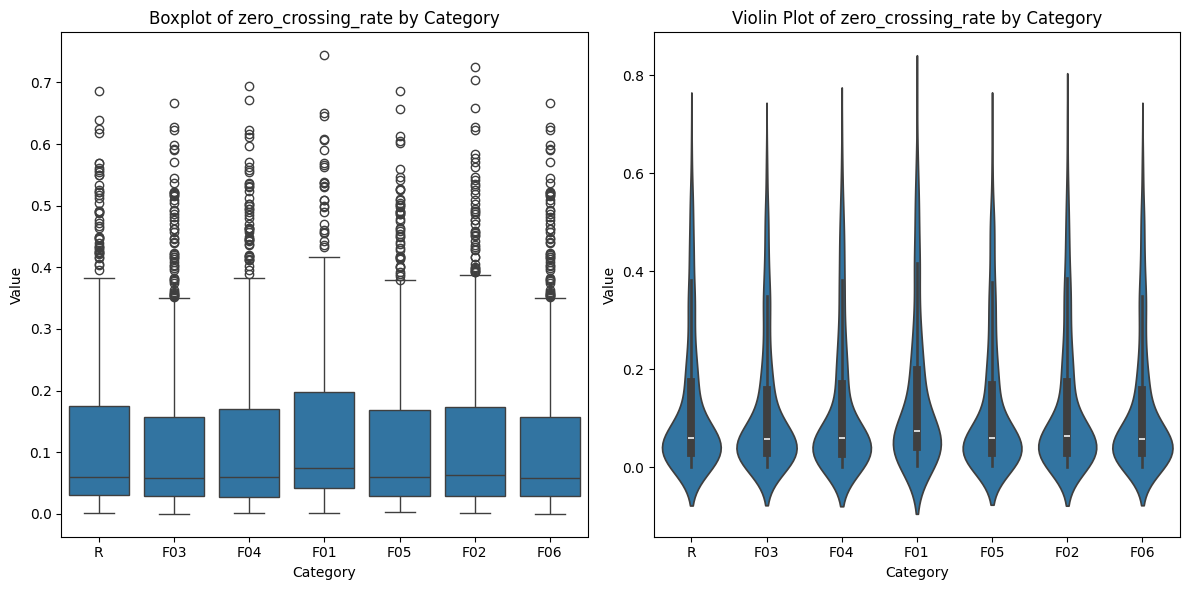

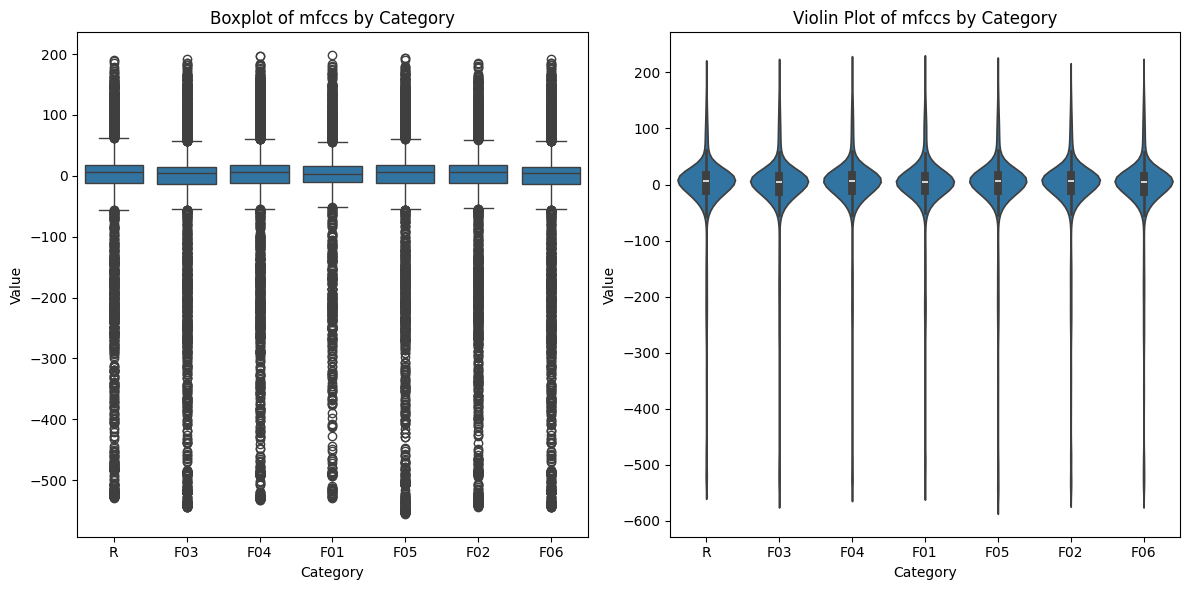

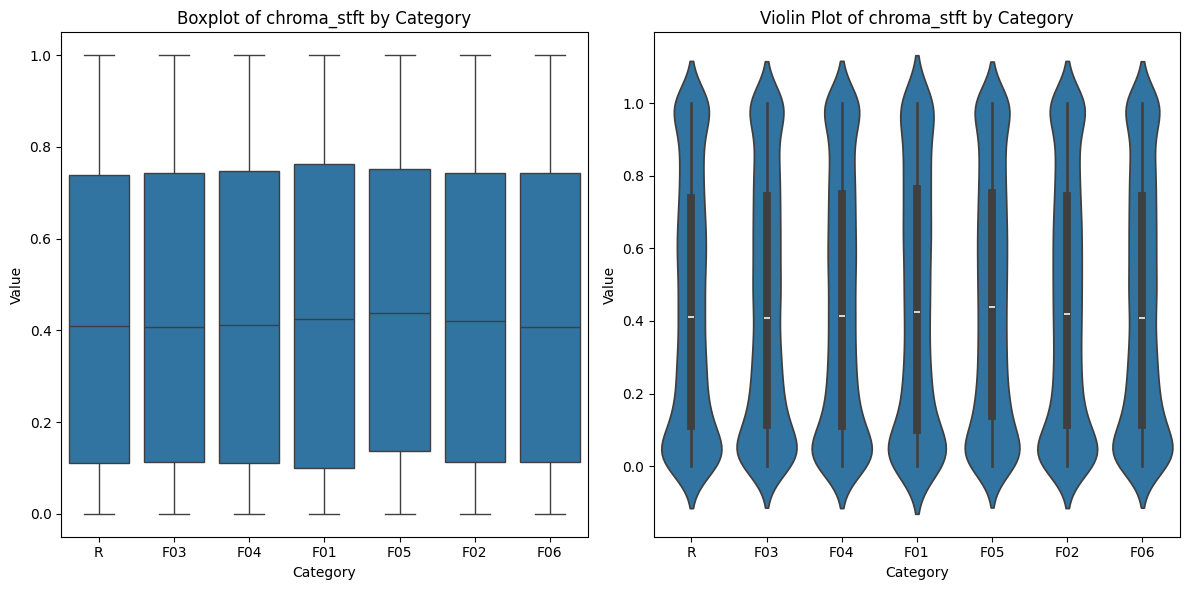

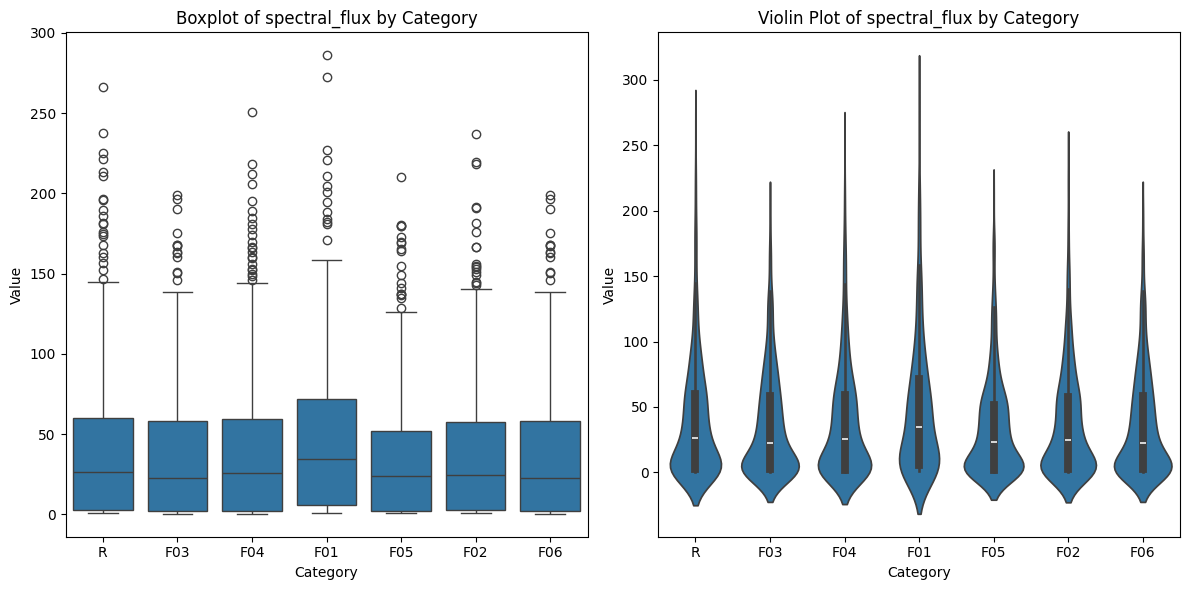

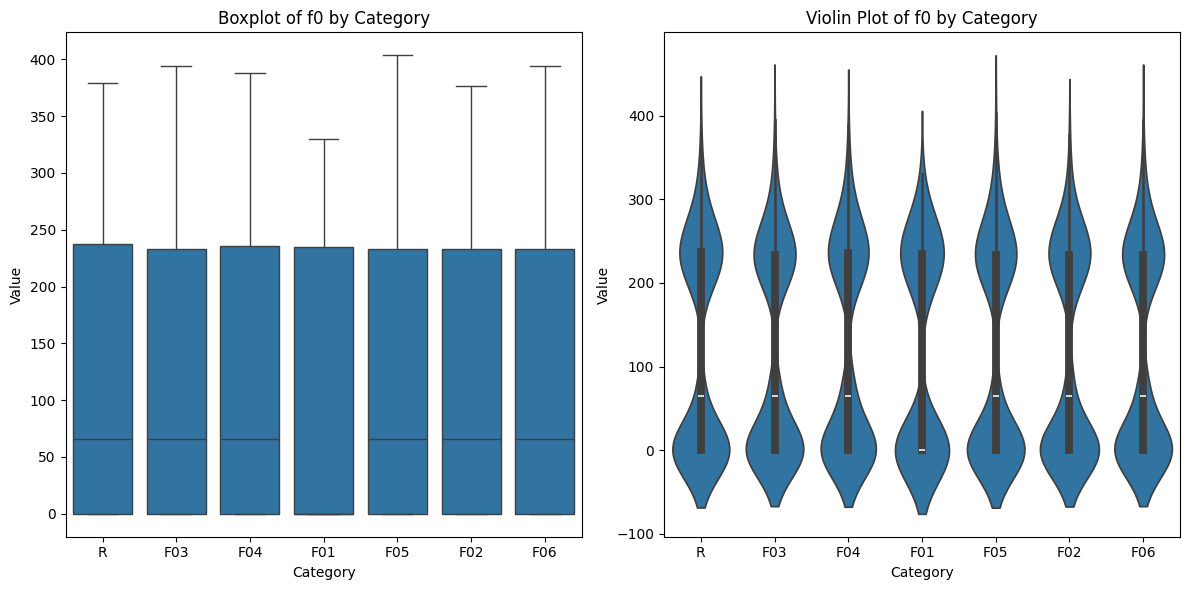

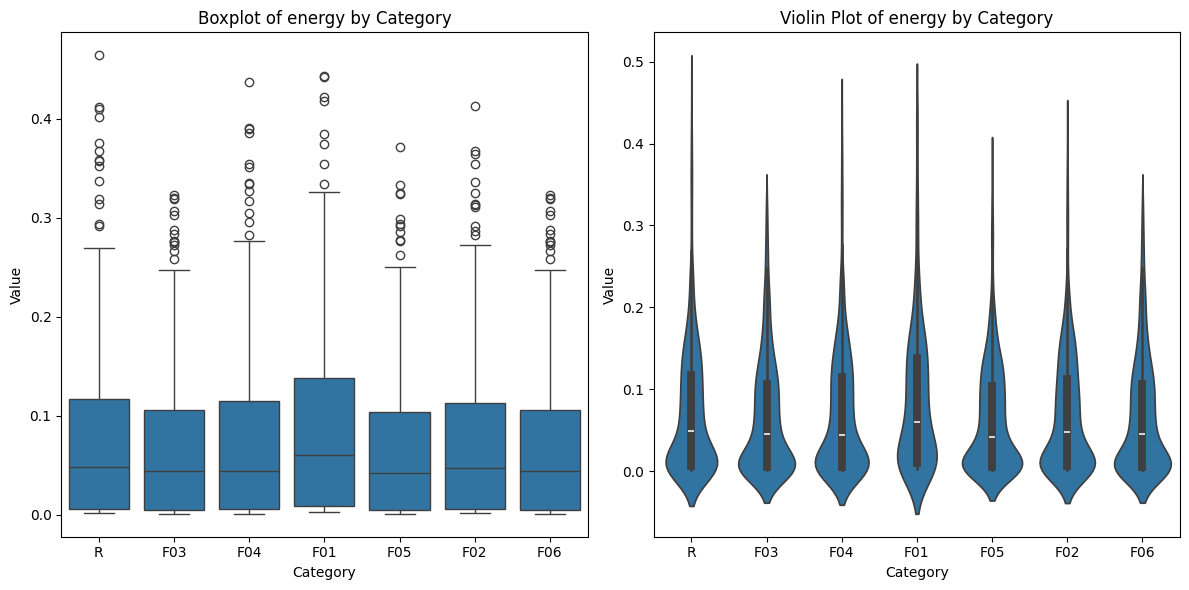

In [10]:
low_level_feature_df = pd.DataFrame(low_level_features)
for feature in [col for col in low_level_feature_df.columns if col not in ['audio_id', 'real_or_fake']]:
    if isinstance(low_level_feature_df[feature].iloc[0], np.ndarray):
        plot_low_level_feature_dist(low_level_feature_df, feature)

**No Obvious/Significant Difference in the distribution of detailed low level features**

In [11]:
del low_level_features
del low_level_feature_df

### Extract High level features

In [12]:
audio_processor = LowLevelFeatureExtractor(target_sr=16000, include_only=['spectral', 'prosodic', 'voice_quality'])
feature_computer = HighLevelFeatureExtractor()

In [13]:
low_level_gen        = audio_processor.low_level_feature_generator(df.iloc[:20])
high_level_features  = list(feature_computer.high_level_feature_generator(low_level_gen))
high_level_features_df = pd.DataFrame(high_level_features)
high_level_features_df

Processing Audios: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]


audio_id real_or_fake  spectral_centroid_mean  spectral_centroid_std  \
0   p225_002            R             1407.277479            1139.511158   
1   p225_002          F03             1269.150323            1085.214354   
2   p225_002          F04             1336.049769            1171.331560   
3   p225_002          F01             1540.345739            1212.507952   
4   p225_002          F05             1414.717840            1149.669533   
5   p225_002          F02             1514.202295            1179.175846   
6   p225_002          F06             1269.150323            1085.214354   
7   p225_003            R             1724.882050            1358.306823   
8   p225_003          F04             1686.359745            1392.656929   
9   p225_003          F03             1700.782291            1308.502013   
10  p225_003          F06             1700.782291            1308.502013   
11  p225_003          F02             1791.209249            1408.466867   
12  p225_003          F05             1740.279417            1358.008199   
13  p225_003          F01             1867.926207            1478.520182   
14  p225_005          F04             1553.217764            1131.104607   
15  p225_005          F03             1581.314247            1099.550237   
16  p225_005            R             1605.708773            1099.336588   
17  p225_005          F06             1581.314247            1099.550237   
18  p225_005          F02             1677.229296            1156.060546   
19  p225_005          F05             1608.073380            1074.416395   

    spectral_centroid_var  spectral_centroid_min  spectral_centroid_max  \
0            1.298486e+06             273.979621            4860.736866   
1            1.177690e+06             319.092868            4752.988182   
2            1.372018e+06             247.256673            4922.406802   
3            1.470176e+06             257.468837            5074.111834   
4            1.321740e+06             295.103707            4982.683428   
5            1.390456e+06             275.770102            5091.169775   
6            1.177690e+06             319.092868            4752.988182   
7            1.844997e+06             240.330124            5445.572581   
8            1.939493e+06             168.940520            5577.680477   
9            1.712178e+06             289.027907            5388.677656   
10           1.712178e+06             289.027907            5388.677656   
11           1.983779e+06             236.626324            5761.676749   
12           1.844186e+06             277.044296            5580.742488   
13           2.186022e+06             257.929241            5768.435948   
14           1.279398e+06             209.275100            5329.144045   
15           1.209011e+06             453.713344            5294.671488   
16           1.208541e+06             301.962245            5259.902010   
17           1.209011e+06             453.713344            5294.671488   
18           1.336476e+06             274.291738            5681.442518   
19           1.154371e+06             313.896633            5236.565437   

    spectral_centroid_range  spectral_centroid_25th_percentile  \
0               4586.757245                         538.847218   
1               4433.895314                         501.144619   
2               4675.150129                         433.114366   
3               4816.642997                         688.193002   
4               4687.579722                         604.047516   
5               4815.399673                         634.001211   
6               4433.895314                         501.144619   
7               5205.242457                         856.539372   
8               5408.739957                         814.810942   
9               5099.649749                         845.365038   
10              5099.649749                         845.365038   
11              5525.050425            

**Using Parallel Processing**

In [14]:
def extract_features(row, audio_processor, feature_computer):
    low_level_features = audio_processor.extract_features(row)
    high_level_features = feature_computer.compute_high_level_features(low_level_features)
    return high_level_features


In [15]:
audio_processor  = LowLevelFeatureExtractor(target_sr=16000, include_only=['spectral', 'prosodic', 'voice_quality'])
feature_computer = HighLevelFeatureExtractor()

high_level_features   = Parallel(n_jobs=5)(delayed(extract_features)(row, audio_processor, feature_computer) for _, row in df.iterrows())
high_level_feature_df = pd.DataFrame(high_level_features)
high_level_feature_df

audio_id real_or_fake  spectral_centroid_mean  spectral_centroid_std  \
0     p225_002            R             1407.277479            1139.511158   
1     p225_002          F03             1269.150323            1085.214354   
2     p225_002          F04             1336.049769            1171.331560   
3     p225_002          F01             1540.345739            1212.507952   
4     p225_002          F05             1414.717840            1149.669533   
...        ...          ...                     ...                    ...   
3495  p227_037            R             1552.956324             999.075044   
3496  p227_037          F05             1576.434714             984.655802   
3497  p227_037          F01             1664.541240            1019.091773   
3498  p227_037          F06             1420.889072            1039.009012   
3499  p227_037          F02             1628.554548             985.262155   

      spectral_centroid_var  spectral_centroid_min  spectral_centroid_max  \
0              1.298486e+06             273.979621            4860.736866   
1              1.177690e+06             319.092868            4752.988182   
2              1.372018e+06             247.256673            4922.406802   
3              1.470176e+06             257.468837            5074.111834   
4              1.321740e+06             295.103707            4982.683428   
...                     ...                    ...                    ...   
3495           9.981509e+05             388.172970            4600.922167   
3496           9.695470e+05             498.677006            4551.413890   
3497           1.038548e+06             363.770847            4487.643623   
3498           1.079540e+06             323.817544            4574.689581   
3499           9.707415e+05             392.120201            4541.137634   

      spectral_centroid_range  spectral_centroid_25th_percentile  \
0                 4586.757245                         538.847218   
1                 4433.895314                         501.144619   
2                 4675.150129                         433.114366   
3                 4816.642997                         688.193002   
4                 4687.579722                         604.047516   
...                       ...                                ...   
3495              4212.749197                         882.891409   
3496              4052.736884                         933.510378   
3497              4123.872775                        1012.747287   
3498              4250.872037                         711.868542   
3499              4149.017433                         977.733230   

      spectral_centroid_50th_percentile  ...      F3_mean    F3_stdev  \
0                           1075.098178  ...  3049.531361  494.567763   
1                            872.714022  ...  3043.040662  519.790781   
2                            997.420786  ...  3065.190896  526.464769   
3                           1217.335638  ...  3026.219415  501.378510   
4                           1091.148701  ...  3070.330027  497.115083   
...                                 ...  ...          ...         ...   
3495                        1258.618262  ...  3188.454815  447.833566   
3496                        1286.137045  ...  3172.114080  425.698193   
3497                        1364.705405  ...  3137.924622  535.900156   
3498                        1094.667566  ...  3114.526501  481.245274   
3499                        1284.472968  ...  3171.024082  443.406471   

      jitter_local  jitter_rap  jitter_ppq5  shimmer_local  shimmer_apq3  \
0         0.019678    0.008011     0.009951       0.071643      0.020144   
1         0.023747    0.009809     0.010080       0.069989      0.020712   
2         0.021938    0.009088     0.011882       0.101849      0.041155   
3         0.023562    0.010110     0.010417       0.068337      0.023278   
4         0.025659    0.010528     0.014228       0.090644      0.0324

In [16]:
high_level_feature_df.columns[high_level_feature_df.isna().sum() > 0]

Index(['f0_skew', 'f0_kurtosis', 'pause_mean', 'pause_std', 'pause_var',
       'pause_min', 'pause_max', 'pause_range', 'pause_25th_percentile',
       'pause_50th_percentile', 'pause_75th_percentile', 'pause_skew',
       'pause_kurtosis'],
      dtype='object')

In [17]:
stats_df = perform_statistical_tests(high_level_feature_df)
stats_df

feature    t_stat       t_p_val    u_stat       u_p_val  \
0    spectral_centroid_mean  1.369696  1.712243e-01  781180.0  1.361053e-01   
1     spectral_centroid_std -0.722790  4.700574e-01  734608.0  4.618832e-01   
2     spectral_centroid_var -0.764145  4.450448e-01  734608.0  4.618832e-01   
3     spectral_centroid_min  2.738781  6.318347e-03  835249.0  4.599935e-05   
4     spectral_centroid_max  0.114091  9.091987e-01  752626.0  9.001238e-01   
..                      ...       ...           ...       ...           ...   
382           shimmer_local -3.576043  3.729168e-04  678343.0  6.140152e-04   
383            shimmer_apq3 -9.869035  8.862976e-22  578186.0  2.155795e-16   
384            shimmer_apq5 -6.788167  2.279717e-11  620505.0  6.011186e-10   
385             shimmer_dda -9.869035  8.862976e-22  578186.0  2.155795e-16   
386                     hnr  5.581136  3.413238e-08  877814.0  9.976762e-10   

     effect_size     f_stat       f_p_val  
0       0.065041   1.753959  1.854663e-01  
1      -0.034807   0.516058  4.725763e-01  
2      -0.036664   0.568492  4.509094e-01  
3       0.126855   6.382160  1.157108e-02  
4       0.005457   0.012513  9.109379e-01  
..           ...        ...           ...  
382    -0.169354  11.832329  5.889212e-04  
383    -0.428947  66.237775  5.498481e-16  
384    -0.305130  35.182505  3.294087e-09  
385    -0.428947  66.237775  5.498481e-16  
386     0.263085  28.311360  1.097796e-07  

[387 rows x 8 columns]

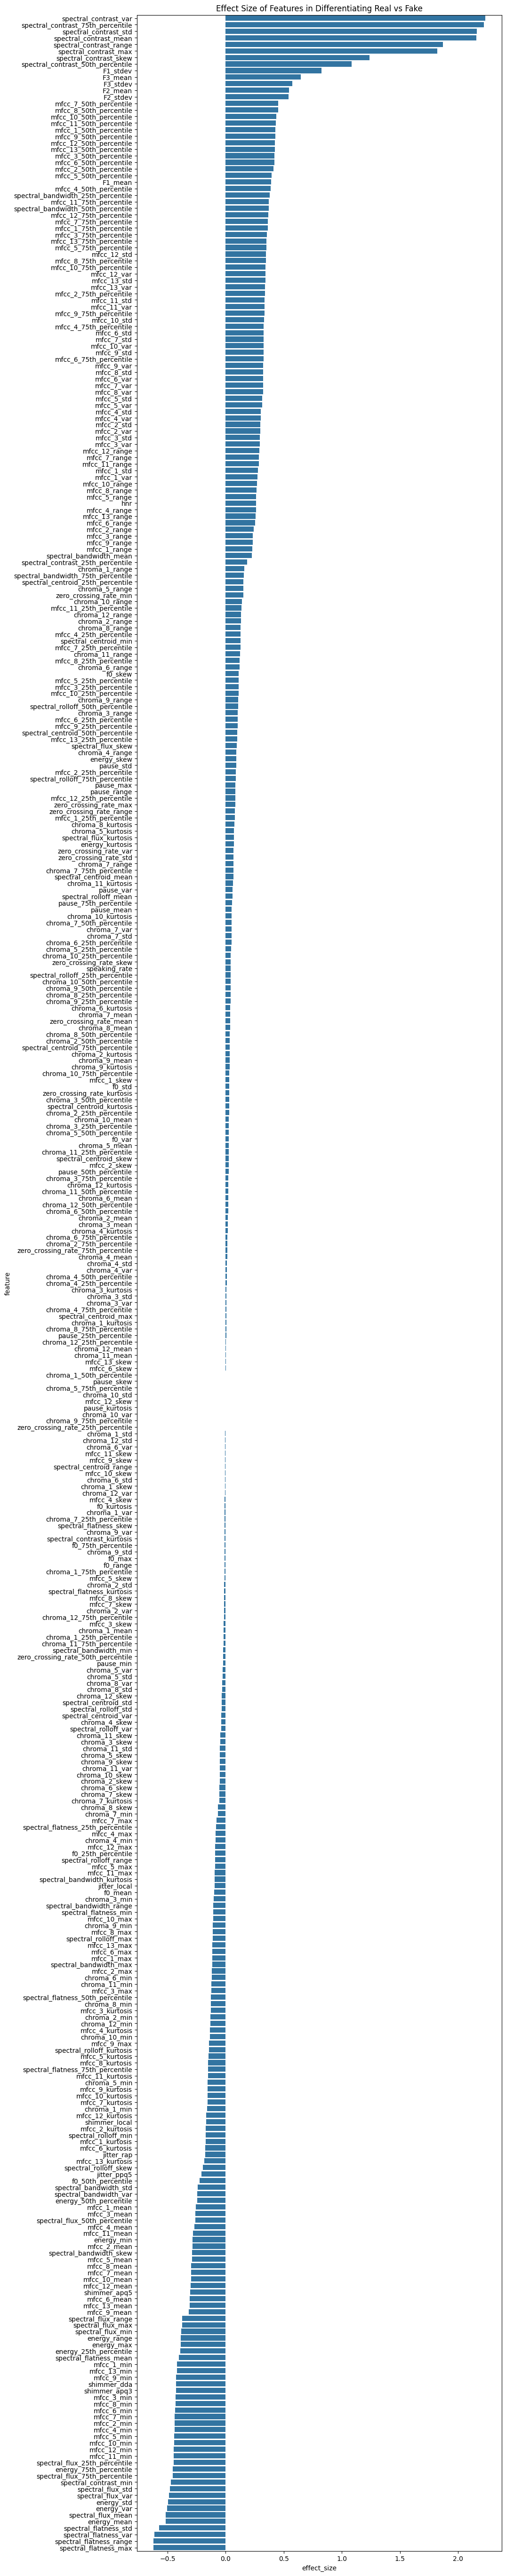

In [18]:
# Visualize the results
plt.figure(figsize=(10, 70))
sns.barplot(x='effect_size', y='feature', data=stats_df.sort_values(by='effect_size', ascending=False))
plt.title('Effect Size of Features in Differentiating Real vs Fake')
plt.show()

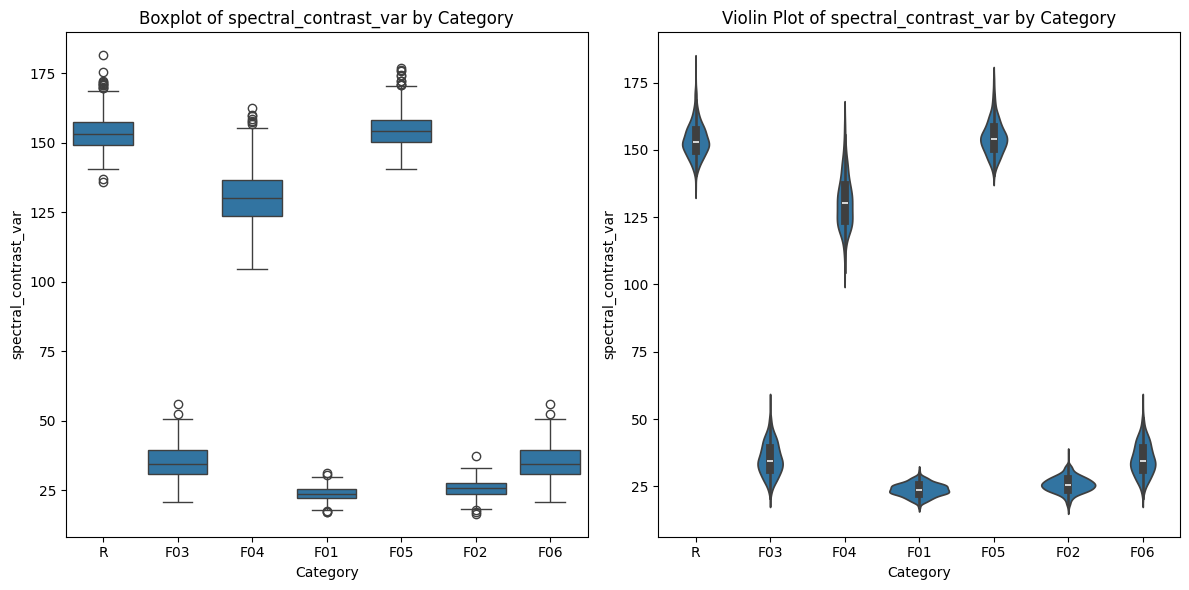

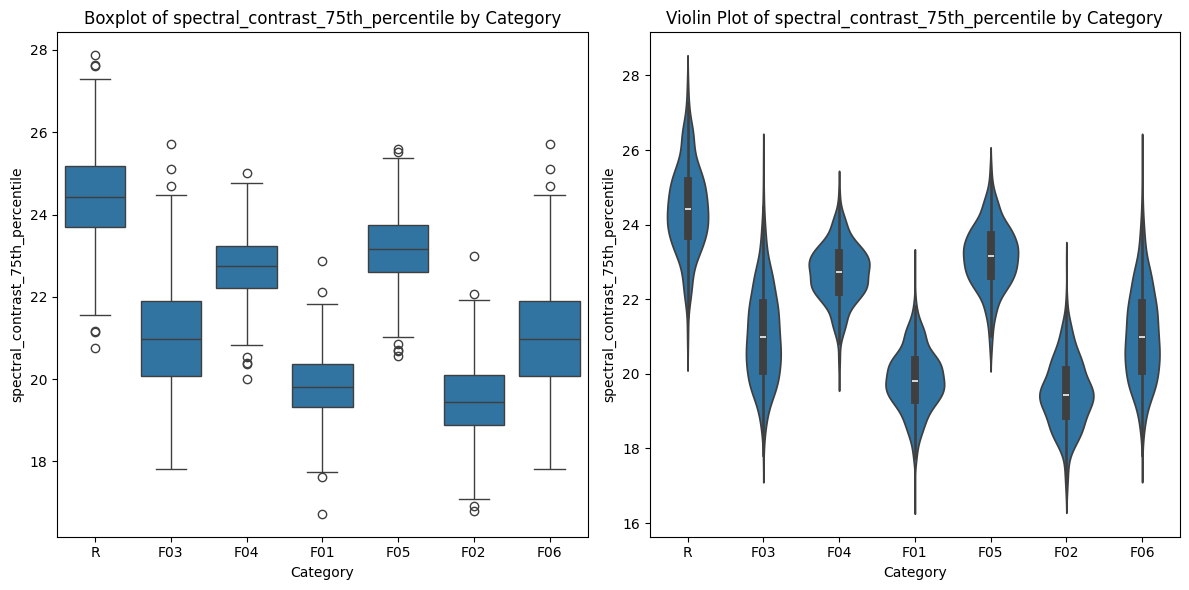

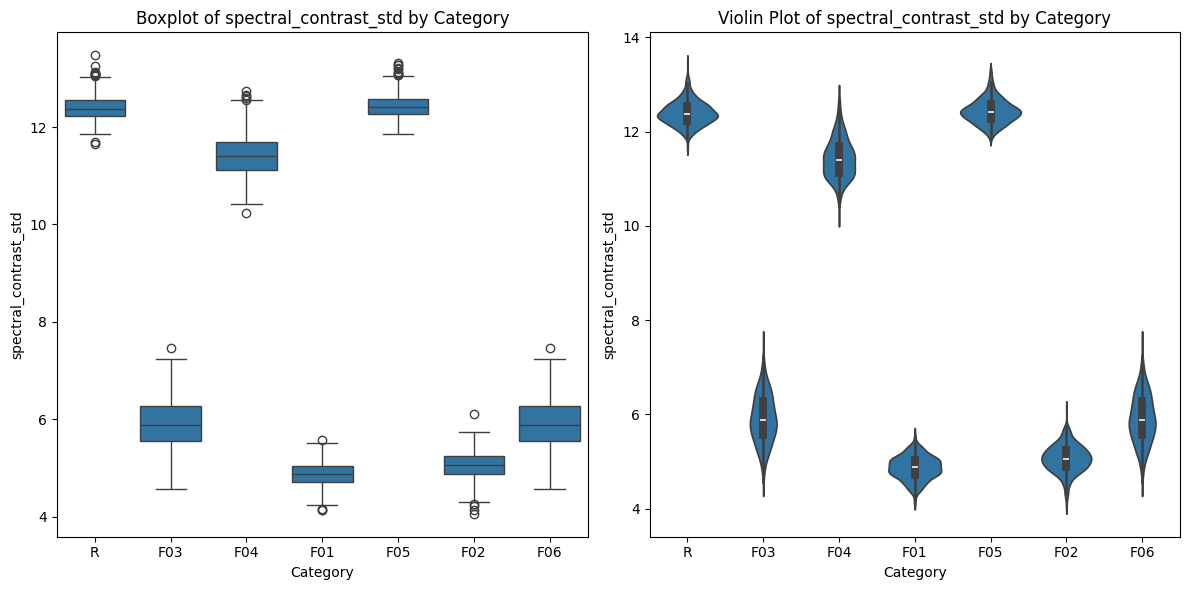

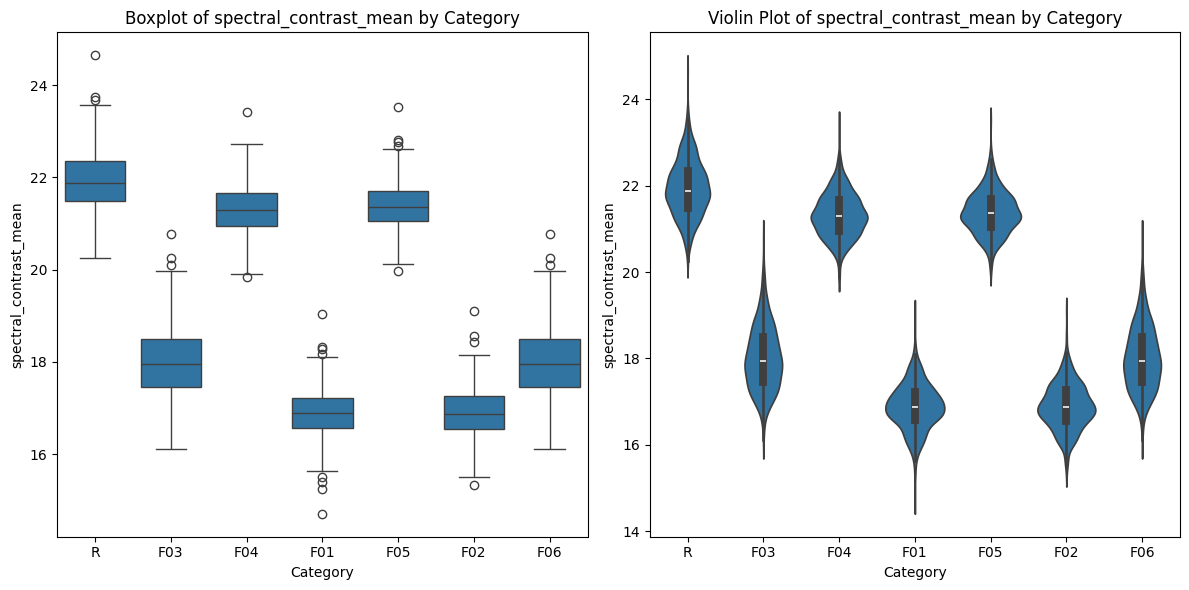

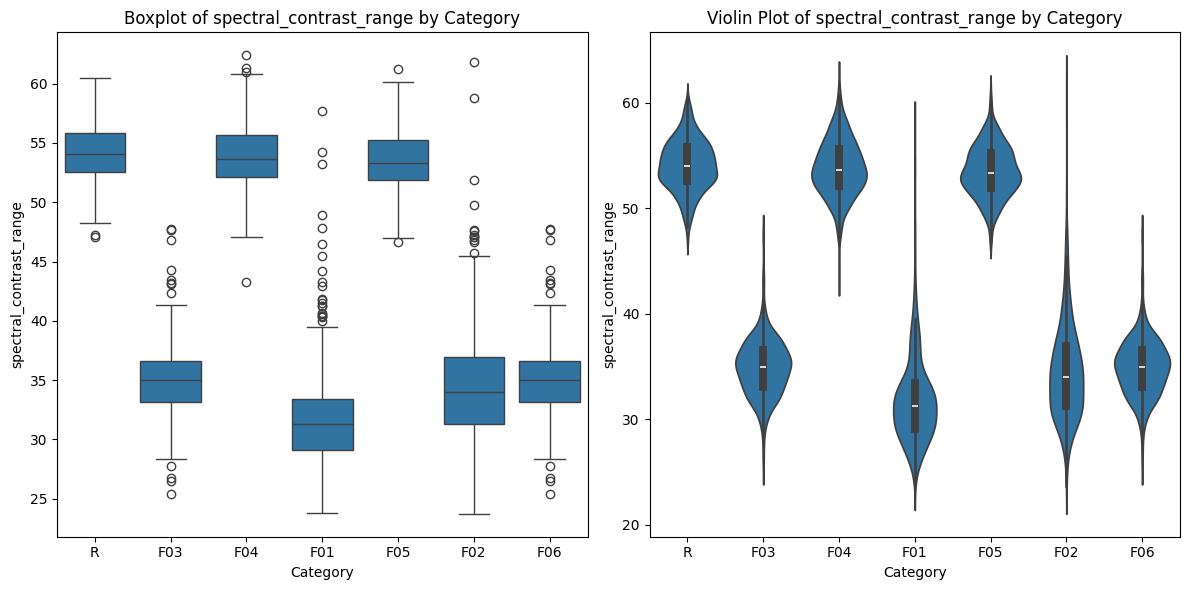

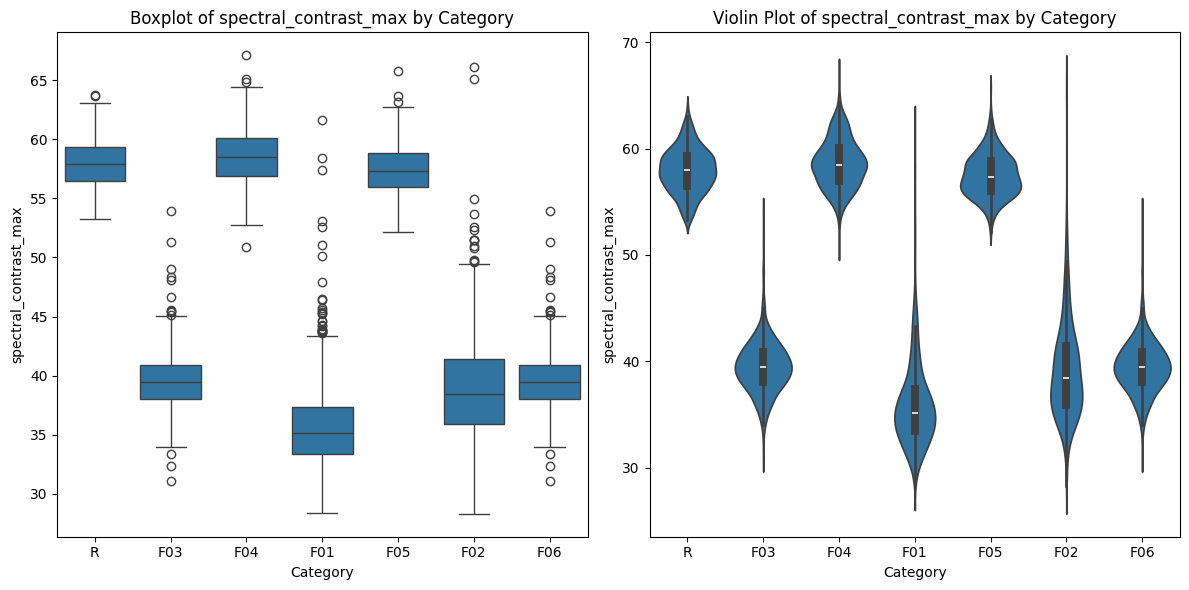

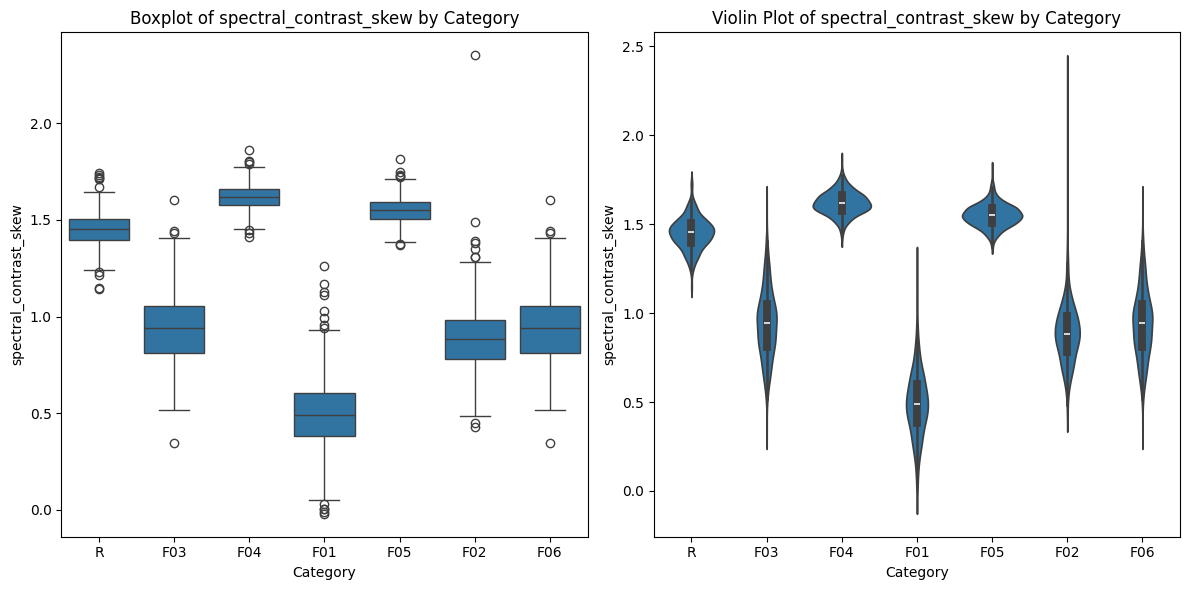

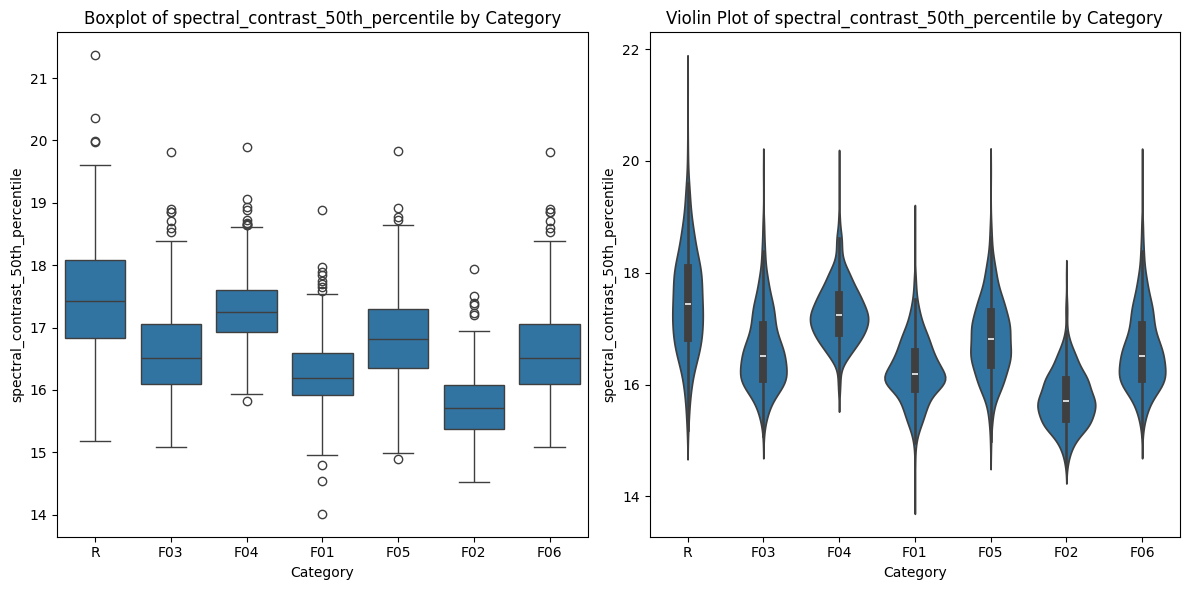

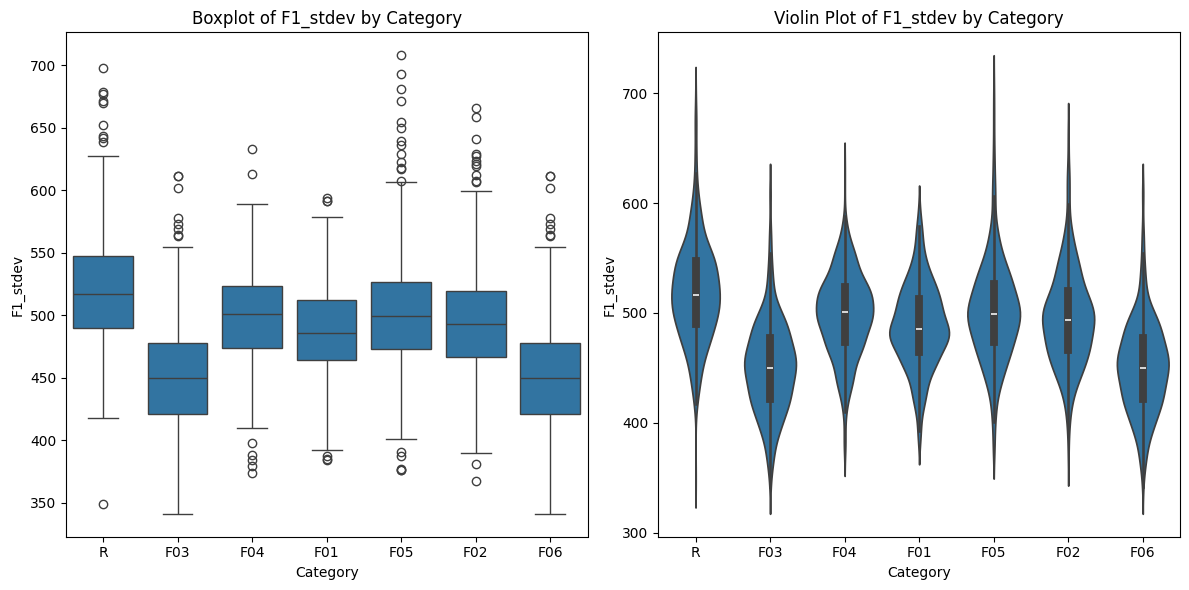

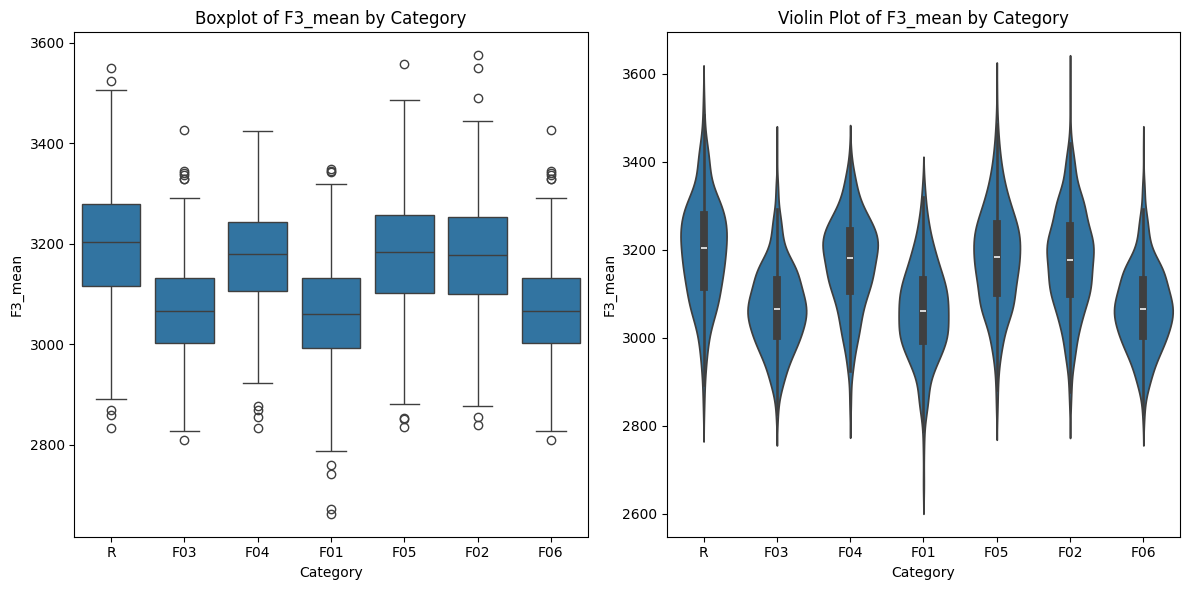

In [19]:
all_features = stats_df.sort_values(by=['effect_size'], ascending=False).feature.tolist()
plot_high_level_feature_dist(high_level_feature_df, all_features[:10])

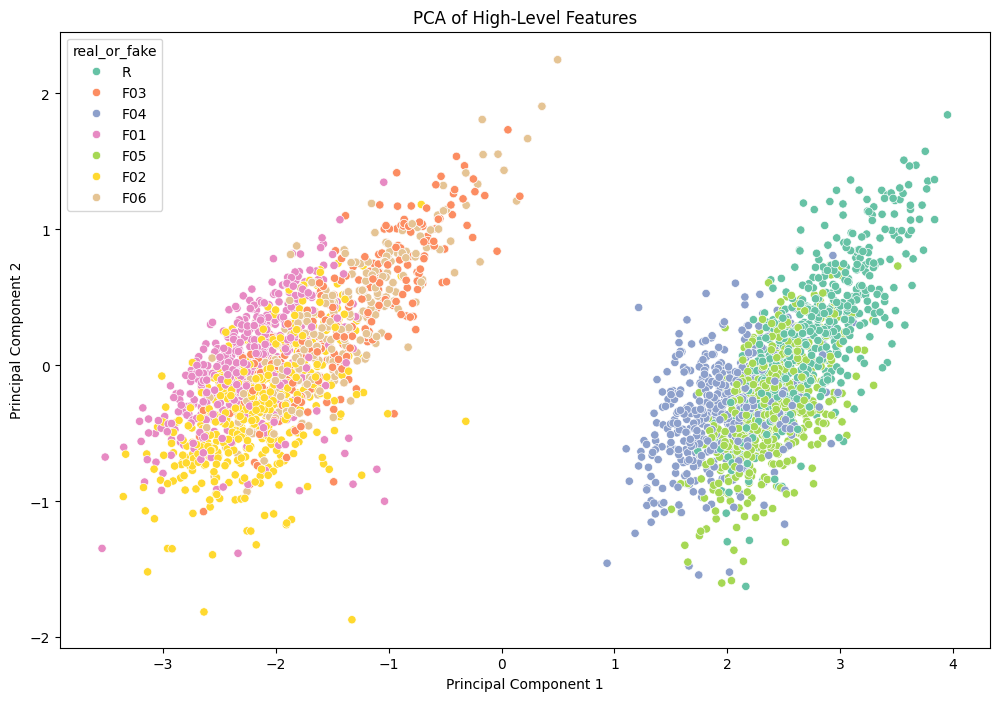

In [28]:
perform_pca_and_plot(high_level_feature_df, all_features[:5])

In [29]:
def logistic_regression_feature_importance(df, selected_features, target_column='real_or_fake'):
    # Drop columns with NaN values
    df_clean = df.dropna(axis=1)
    
    # Ensure selected features are in the cleaned DataFrame
    selected_features = [feature for feature in selected_features if feature in df_clean.columns]

    X = df_clean[selected_features]
    y = df_clean[target_column].apply(lambda x: 1 if x == 'R' else 0)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = LogisticRegression()
    model.fit(X_scaled, y)
    
    feature_importances = model.coef_[0]
    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)

    return importance_df

importance_df = logistic_regression_feature_importance(high_level_feature_df, all_features)
importance_df

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


feature  importance
1    spectral_contrast_75th_percentile    3.255801
272                       jitter_local    2.488753
3               spectral_contrast_mean    2.280158
7    spectral_contrast_50th_percentile    2.030413
9                              F3_mean    1.508974
..                                 ...         ...
6               spectral_contrast_skew   -1.154831
361             energy_75th_percentile   -1.281672
313                         jitter_rap   -1.344335
11                             F2_mean   -2.069222
220         spectral_contrast_kurtosis   -2.996905

[374 rows x 2 columns]

### Redundant Features

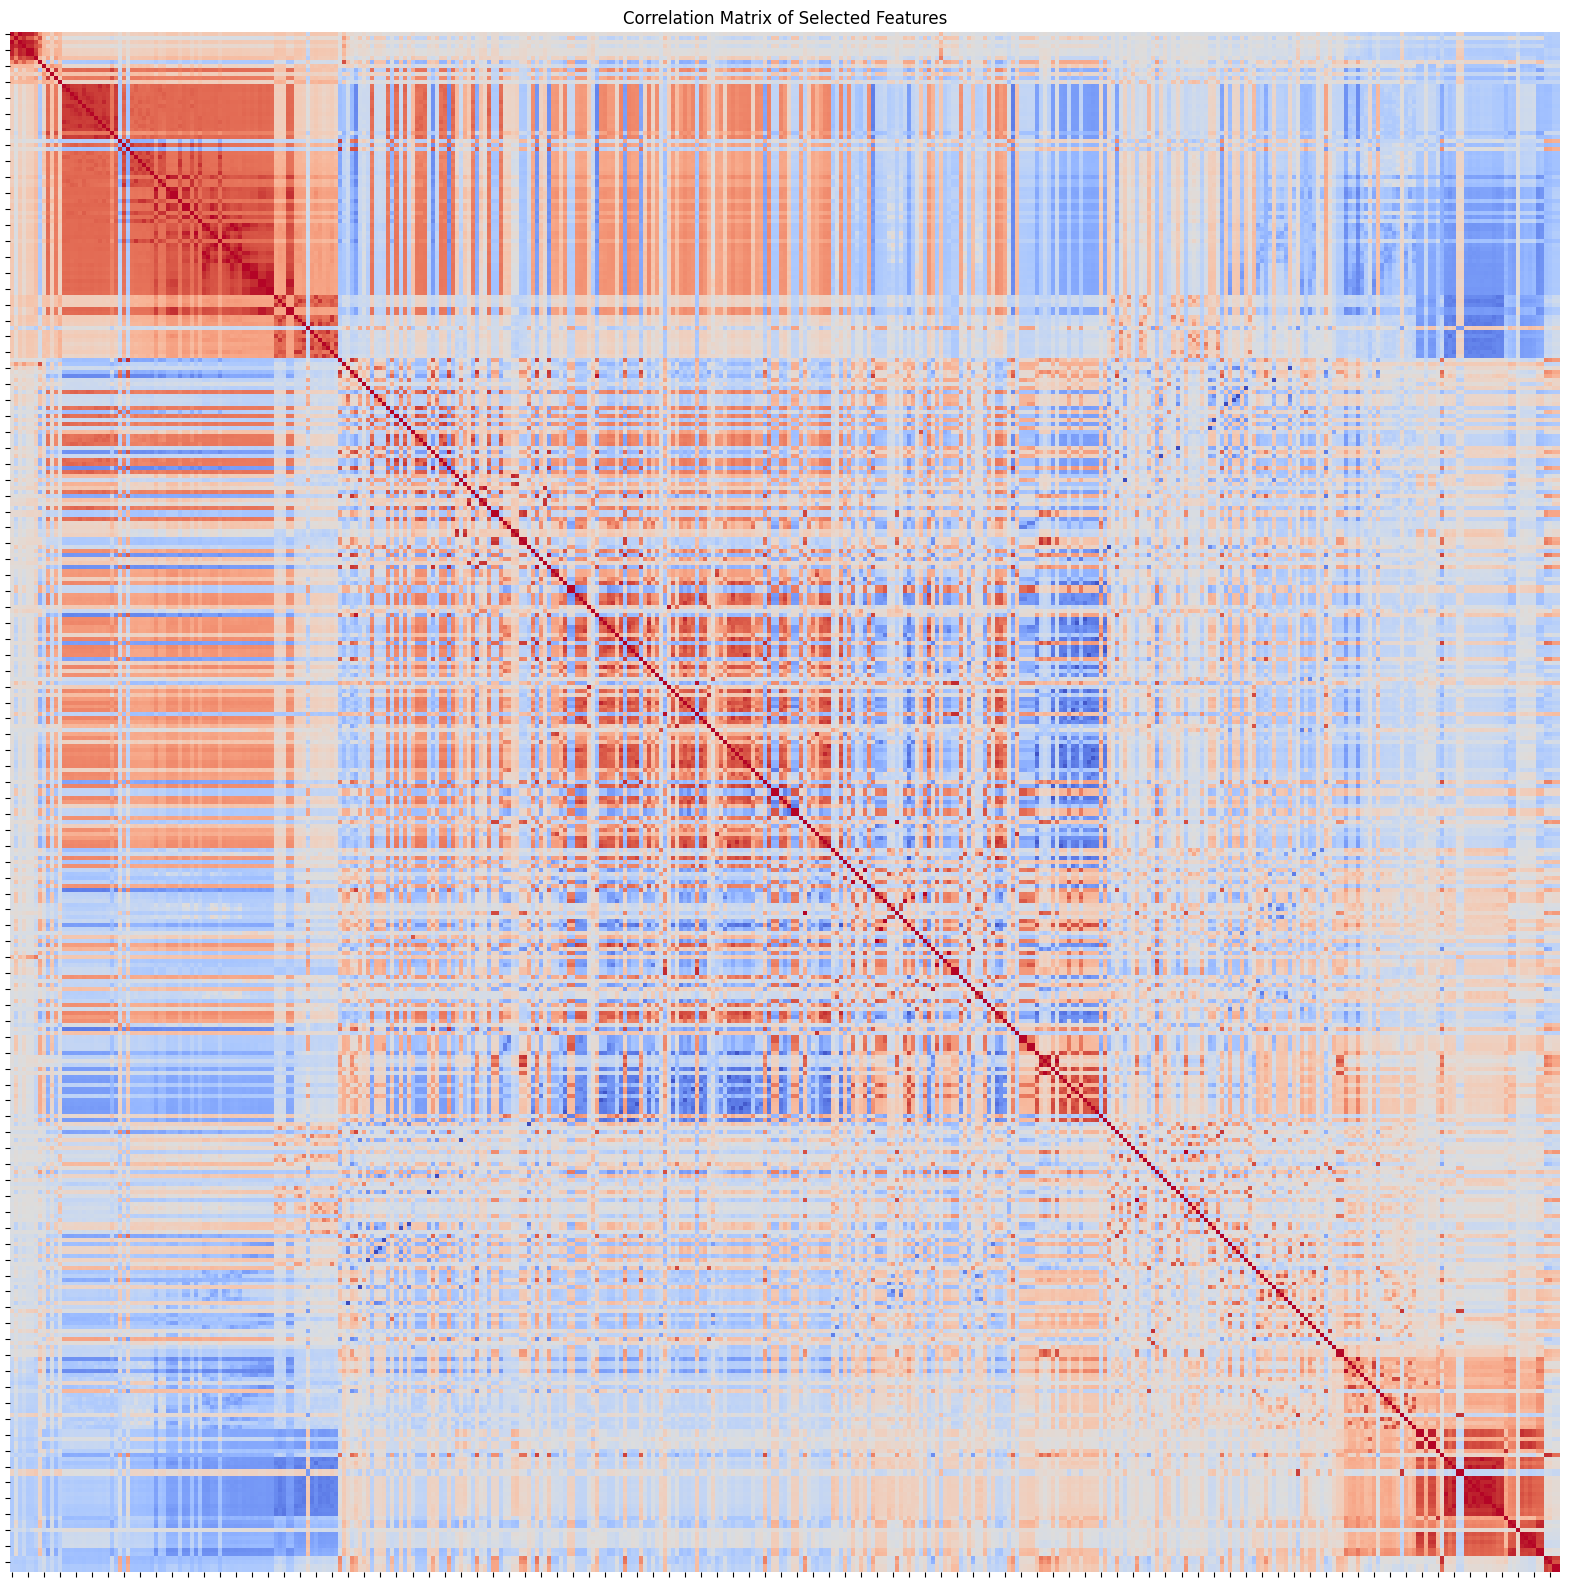

In [30]:
def compute_correlation_matrix(df, selected_features):
    return df[selected_features].corr()

correlation_matrix = compute_correlation_matrix(high_level_feature_df, all_features)

plt.figure(figsize=(20, 20))
ax = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title('Correlation Matrix of Selected Features')
plt.show()

In [31]:
def remove_highly_correlated_features(df, selected_features, threshold=0.6):
    correlation_matrix = df[selected_features].corr().abs()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

    # Remove redundant features
    reduced_features = [feature for feature in selected_features if feature not in to_drop]

    return reduced_features


reduced_features = remove_highly_correlated_features(high_level_feature_df, all_features)
print(f"Reduced Features: {reduced_features}")


Reduced Features: ['spectral_contrast_var', 'F1_stdev', 'F3_mean', 'F3_stdev', 'F2_stdev', 'spectral_bandwidth_25th_percentile', 'mfcc_12_range', 'hnr', 'chroma_1_range', 'chroma_5_range', 'zero_crossing_rate_min', 'chroma_10_range', 'chroma_8_range', 'f0_skew', 'spectral_flux_skew', 'pause_std', 'zero_crossing_rate_max', 'chroma_8_kurtosis', 'chroma_7_75th_percentile', 'chroma_11_kurtosis', 'pause_75th_percentile', 'chroma_7_var', 'zero_crossing_rate_skew', 'chroma_2_kurtosis', 'mfcc_1_skew', 'f0_std', 'mfcc_6_skew', 'mfcc_9_skew', 'mfcc_4_skew', 'spectral_bandwidth_min', 'mfcc_12_max', 'f0_25th_percentile', 'jitter_local', 'f0_50th_percentile', 'mfcc_11_mean', 'energy_min', 'spectral_contrast_min']


In [32]:
high_level_feature_df[reduced_features].dropna().isna().sum()

spectral_contrast_var                 0
F1_stdev                              0
F3_mean                               0
F3_stdev                              0
F2_stdev                              0
spectral_bandwidth_25th_percentile    0
mfcc_12_range                         0
hnr                                   0
chroma_1_range                        0
chroma_5_range                        0
zero_crossing_rate_min                0
chroma_10_range                       0
chroma_8_range                        0
f0_skew                               0
spectral_flux_skew                    0
pause_std                             0
zero_crossing_rate_max                0
chroma_8_kurtosis                     0
chroma_7_75th_percentile              0
chroma_11_kurtosis                    0
pause_75th_percentile                 0
chroma_7_var                          0
zero_crossing_rate_skew               0
chroma_2_kurtosis                     0
mfcc_1_skew                           0


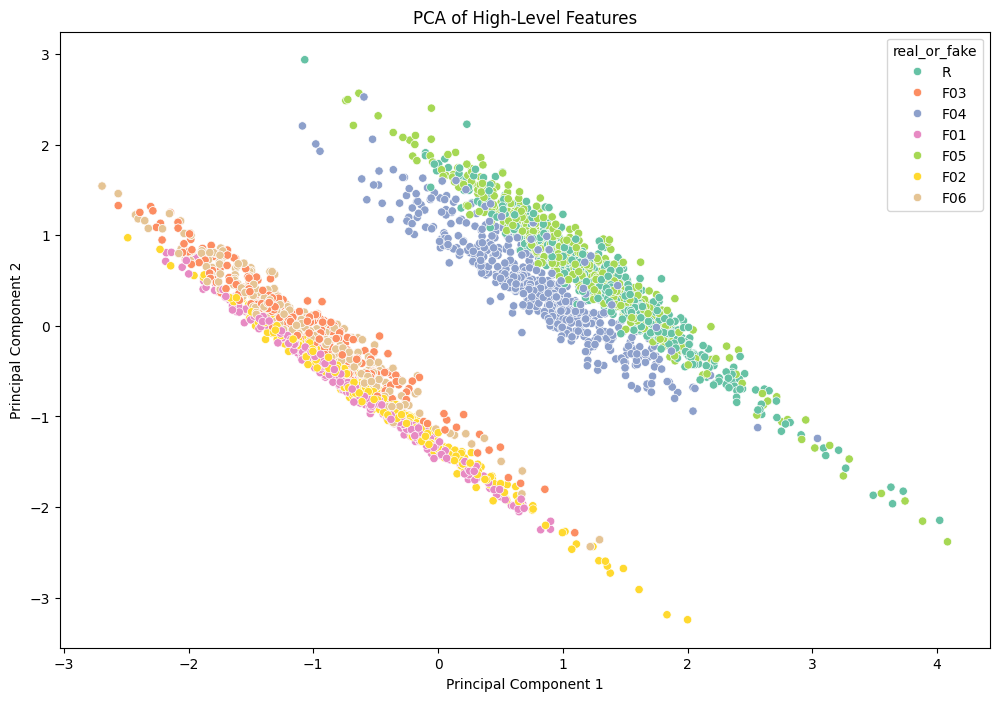

In [33]:
perform_pca_and_plot(high_level_feature_df, reduced_features[:20])

In [34]:
importance_df = logistic_regression_feature_importance(high_level_feature_df, reduced_features)
importance_df

feature  importance
0                spectral_contrast_var    3.871487
7                                  hnr    1.221296
14              zero_crossing_rate_max    0.621165
3                             F3_stdev    0.584416
5   spectral_bandwidth_25th_percentile    0.500258
2                              F3_mean    0.429275
32                          energy_min    0.341663
24                         mfcc_9_skew    0.253099
1                             F1_stdev    0.252534
4                             F2_stdev    0.230783
21                         mfcc_1_skew    0.189297
18                        chroma_7_var    0.184936
15                   chroma_8_kurtosis    0.169766
31                        mfcc_11_mean    0.106425
25                         mfcc_4_skew    0.086248
26              spectral_bandwidth_min    0.086034
17                  chroma_11_kurtosis    0.052827
29                        jitter_local    0.037227
11                     chroma_10_range    0.027129
23                         mfcc_6_skew    0.024648
12                      chroma_8_range   -0.051089
9                       chroma_5_range   -0.073585
33               spectral_contrast_min   -0.117218
20                   chroma_2_kurtosis   -0.127384
13                  spectral_flux_skew   -0.148610
8                       chroma_1_range   -0.151824
28                  f0_25th_percentile   -0.166034
30                  f0_50th_percentile   -0.177376
16            chroma_7_75th_percentile   -0.187735
6                        mfcc_12_range   -0.193065
27                         mfcc_12_max   -0.193927
19             zero_crossing_rate_skew   -0.279218
10              zero_crossing_rate_min   -0.299364
22                              f0_std   -0.519958

### Baseline Model

In [35]:
good_features = reduced_features
imputer = SimpleImputer(strategy='mean')

In [36]:
X = high_level_feature_df[good_features]
X = imputer.fit_transform(X)
y = high_level_feature_df['real_or_fake'].apply(lambda x: 1 if x == 'R' else 0)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

model_performance = {}

for model_name, model in models.items():

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Fake', 'Real'])
    
    model_performance[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Classification Report': report
    }


for model_name, metrics in model_performance.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print("Classification Report:\n", metrics['Classification Report'])
    print("-" * 60)


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Accuracy: 0.9014
Precision: 0.7158
Recall: 0.6182
F1 Score: 0.6634
Classification Report:
               precision    recall  f1-score   support

        Fake       0.93      0.95      0.94       590
        Real       0.72      0.62      0.66       110

    accuracy                           0.90       700
   macro avg       0.82      0.79      0.80       700
weighted avg       0.90      0.90      0.90       700

------------------------------------------------------------
Model: Random Forest
Accuracy: 0.8814
Precision: 0.7077
Recall: 0.4182
F1 Score: 0.5257
Classification Report:
               precision    recall  f1-score   support

        Fake       0.90      0.97      0.93       590
        Real       0.71      0.42      0.53       110

    accuracy                           0.88       700
   macro avg       0.80      0.69      0.73       700
weighted avg       0.87      0.88      0.87       700

-------------------------------------------------------